In [1]:
import numpy as np

In [2]:
from scipy.io import loadmat

In [3]:
import matplotlib 
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

In [5]:
data_path = '/Users/linggeli/neuroscience/data/SuperChris/super_chris_extraction_odor2s.mat'
data_odor = loadmat(data_path)

In [6]:
trial_info = data_odor['trialInfo']
select_odor_B = (trial_info[:, 0] == 1) & (trial_info[:, 1] == 1) & (trial_info[:, 3] == 2)
select_odor_C = (trial_info[:, 0] == 1) & (trial_info[:, 1] == 1) & (trial_info[:, 3] == 3)
lfp_odor_B = data_odor['lfpEpoch'][select_odor_B, 2000:3000, :]
lfp_odor_C = data_odor['lfpEpoch'][select_odor_C, 2000:3000, :]

In [7]:
print(data_odor['unitIDs'])  # T13, T23, T15, T22, T14, T19 have the most units

[[array([u'T1-U1'], dtype='<U5') array([u'T1-U2'], dtype='<U5')
  array([u'T1-U3'], dtype='<U5') array([u'T12-U1'], dtype='<U6')
  array([u'T13-U1'], dtype='<U6') array([u'T13-U2'], dtype='<U6')
  array([u'T13-U3'], dtype='<U6') array([u'T13-U4'], dtype='<U6')
  array([u'T13-U5'], dtype='<U6') array([u'T13-U6'], dtype='<U6')
  array([u'T13-U7'], dtype='<U6') array([u'T13-U8'], dtype='<U6')
  array([u'T14-U1'], dtype='<U6') array([u'T14-U2'], dtype='<U6')
  array([u'T14-U3'], dtype='<U6') array([u'T14-U4'], dtype='<U6')
  array([u'T15-U1'], dtype='<U6') array([u'T15-U2'], dtype='<U6')
  array([u'T15-U3'], dtype='<U6') array([u'T15-U4'], dtype='<U6')
  array([u'T15-U5'], dtype='<U6') array([u'T15-U6'], dtype='<U6')
  array([u'T16-U1'], dtype='<U6') array([u'T19-U1'], dtype='<U6')
  array([u'T19-U2'], dtype='<U6') array([u'T19-U3'], dtype='<U6')
  array([u'T19-U4'], dtype='<U6') array([u'T2-U1'], dtype='<U5')
  array([u'T2-U2'], dtype='<U5') array([u'T2-U3'], dtype='<U5')
  array([u'T21-U

In [8]:
lfp_odor_B = lfp_odor_B[:, :, [3, 13, 5, 12, 4, 8]]
lfp_odor_C = lfp_odor_C[:, :, [3, 13, 5, 12, 4, 8]]
print(lfp_odor_B.shape)
print(lfp_odor_C.shape)

(41, 1000, 6)
(37, 1000, 6)


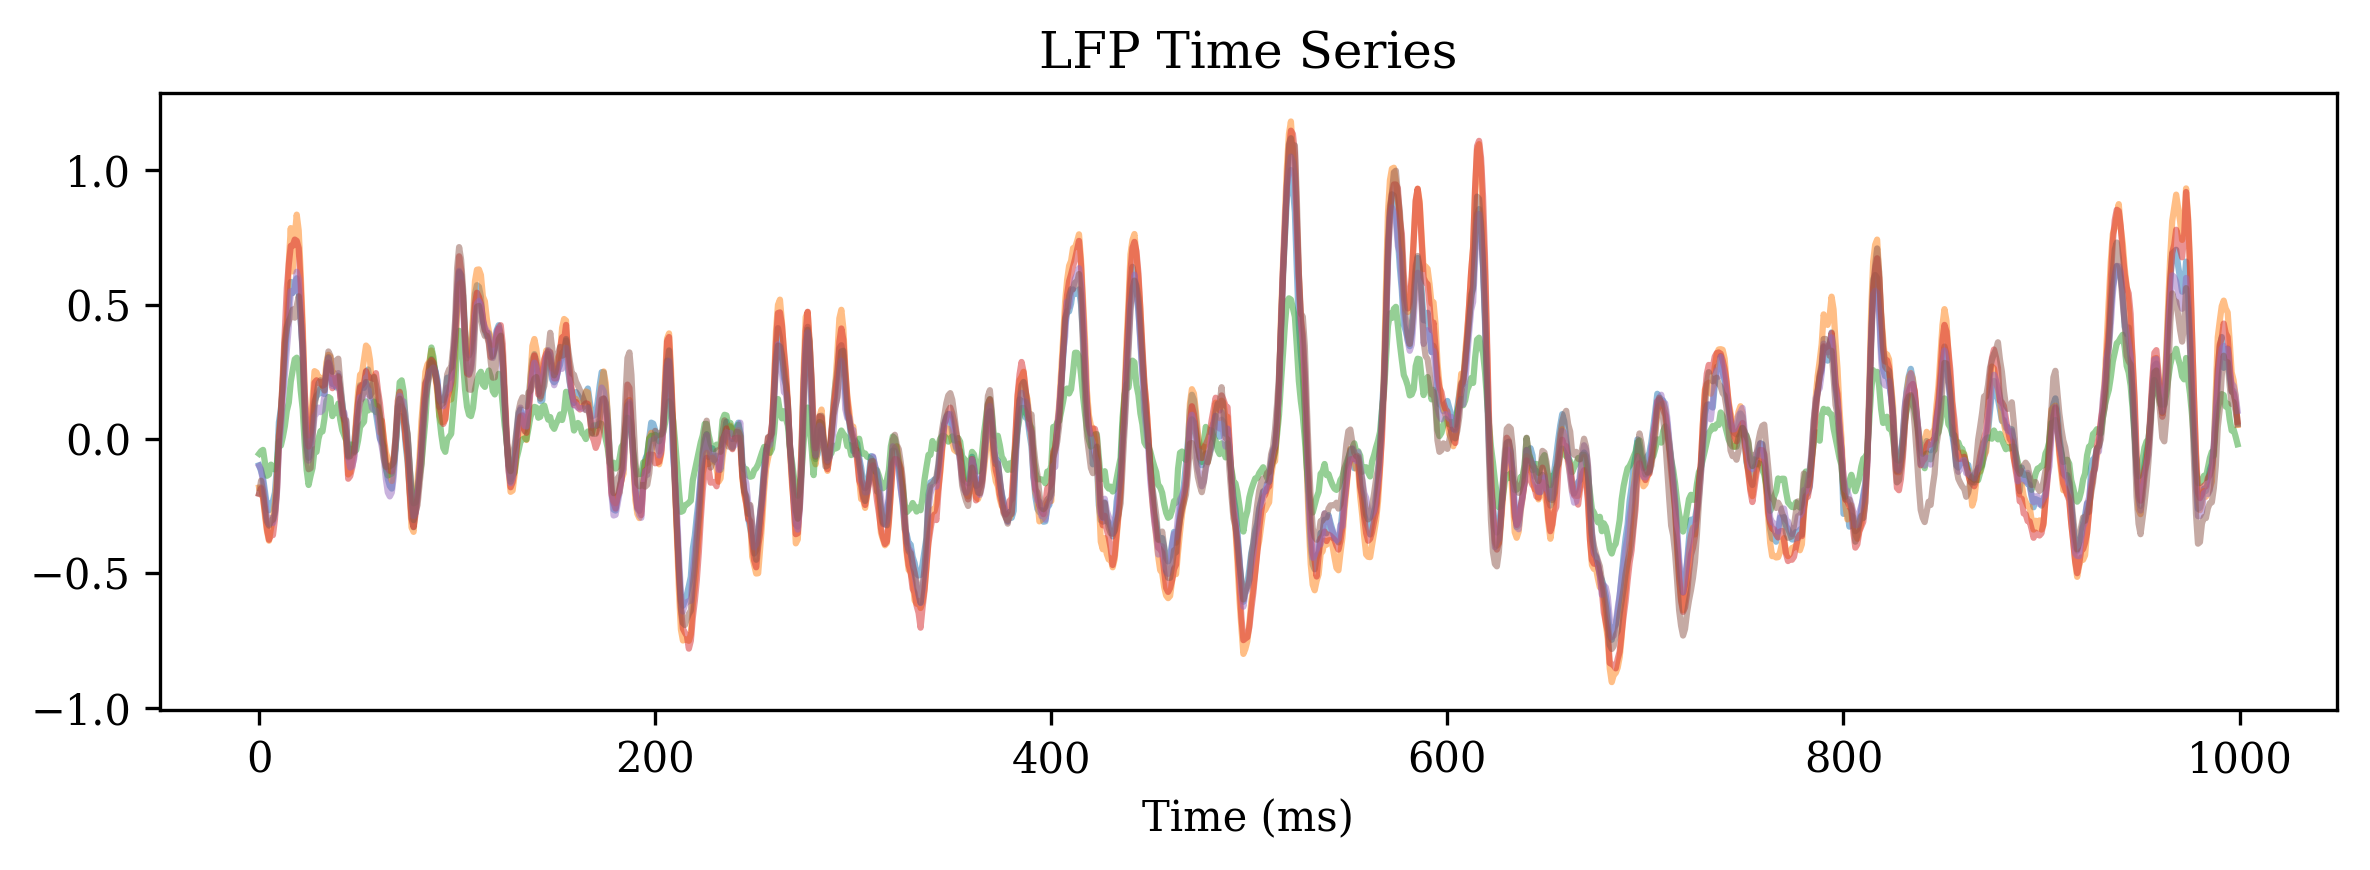

In [9]:
fig = plt.figure(figsize=(8, 3), dpi=300)
for j in range(6):
    plt.plot(lfp_odor_B[0, :, j], alpha=0.5)
plt.title('LFP Time Series')
plt.xlabel('Time (ms)')
fig.tight_layout()
fig.savefig('lfp_time_series.png')
plt.show()

In [9]:
from scipy.linalg import expm, logm

In [10]:
def sliding_window(time_series, size=50, stride=1):
    """
    Calculate sliding window covariance Log-Euclidean vector time series.

    Args
        time_series: (numpy array) [t, n] t observations in time of n dimensional data
        size: (int) sliding window size
        stride: (int) sliding step size
    """
    t, n = time_series.shape
    log_series = np.zeros((int((t - size) / stride), int(0.5 * n * (n + 1))))
    for i in range(int((t - size) / stride)):
        window = time_series[(i * stride):(i * stride + size), :]
        cov = np.cov(window, rowvar=False)
        log_series[i, :] = logm(cov)[np.triu_indices(n)]
    return log_series

In [11]:
from scipy.stats import norm

In [12]:
def gaussian_taper(cov_series, i, size, z):
    """
    Gaussian tapering of estimated covariance series.

    Args
        cov_series: (numpy array) [n, k, k] estimated covariance series
        i: (int) current index
        size: (int) sliding window size
        z: (float) Gaussian shape in terms of z-score
    """
    n = cov_series.shape[0]
    k = cov_series.shape[1]
    start_index = max(0, i - int(size * 0.5))
    end_index = min(n, i + int(size * 0.5))
    cov_window = cov_series[start_index:end_index, :, :]
    left_width = min(i, int(size * 0.5))
    right_width = min(n - i, int(size * 0.5))
    weights = norm.pdf(np.arange(-size * 0.5, size * 0.5, 1), loc=0, scale=size * z)
    weight_window = weights[(int(size * 0.5) - left_width):(int(size * 0.5) + right_width)]
    weight_window = weight_window / np.sum(weight_window)
    cov_hat = np.zeros((k, k))
    for j in range(end_index - start_index):
        cov_hat += cov_window[j, :, :] * weight_window[j]
    return cov_hat


def tapered_sliding_window(time_series, size=50, stride=1, z=0.2):
    """
    Calculate sliding window covariance Log-Euclidean vector time series with Gaussian tapering.

    Args
        time_series: (numpy array) [t, n] t observations in time of n dimensional data
        size: (int) sliding window size
        stride: (int) sliding step size
        z: (float) Gaussian shape in terms of z-score
    """
    t, n = time_series.shape
    cov_series = np.zeros((int((t - size) / stride), n, n))
    log_series = np.zeros((int((t - size) / stride), int(0.5 * n * (n + 1))))
    for i in range(int((t - size) / stride)):
        window = time_series[(i * stride):(i * stride + size), :]
        cov = np.cov(window, rowvar=False)
        cov_series[i, :, :] = cov
    for i in range(int((t - size) / stride)):
        cov_hat = gaussian_taper(cov_series, i, size, z)
        log_series[i, :] = logm(cov_hat)[np.triu_indices(n)]
    return log_series

In [13]:
odor_B_list = []
for i in range(41):
    cov_ts = sliding_window(lfp_odor_B[i, :, :], size=100, stride=20)
    #cov_ts = tapered_sliding_window(lfp_odor_B[i, :, :], size=40)[::20]
    #print(cov_ts.shape)
    odor_B_list.append(cov_ts)

In [14]:
odor_C_list = []
for i in range(37):
    cov_ts = sliding_window(lfp_odor_C[i, :, :], size=100, stride=20)
    #cov_ts = tapered_sliding_window(lfp_odor_C[i, :, :], size=40)[::20]
    odor_C_list.append(cov_ts)

In [15]:
print(odor_B_list[0].shape)
print(odor_C_list[0].shape)

(45, 21)
(45, 21)


In [16]:
all_vector = np.concatenate(odor_B_list + odor_C_list)
Y = all_vector - np.mean(all_vector, axis=0)
print(Y.shape)

(3510, 21)


In [17]:
from factorgp import FactorGP
from inference import run_gibbs

In [18]:
dims = [78, 45, 21, 2]  # n, t, q, r
model = FactorGP(dims, gamma=[5, 1])

In [19]:
results = run_gibbs(Y, model, 5000, 10, 0.2, verbose=False)

100%|██████████| 5000/5000 [1:03:51<00:00,  1.01it/s]


In [10]:
import pickle

In [12]:
with open('/users/linggeli/gp_connectivity/superchris_full_results.pkl', 'rb') as fp:
    results = pickle.load(fp)

In [13]:
F_sample, loading_sample, variance_sample, theta_sample, traces_hist, mse_history = results

In [14]:
def effective_n(chain):
    """
    Calculate the effective sample size of a Markov chain.
    """
    maxlag = 200
    n = chain.shape[0]
    rho = np.zeros(maxlag)
    for i in range(maxlag):
        t = i + 1
        acf = np.corrcoef(chain[t:], chain[:(n - t)])[0, 1]
        if acf < 0:
            break
        rho[i] = acf
    return(n / (1 + np.sum(rho)))

def effective_n_all(chains):
    """
    Call effective_n on multiple chains.
    """
    k = chains.shape[1]
    size = np.zeros(k)
    for i in range(k):
        size[i] = effective_n(chains[:, i])
    return(size)

In [15]:
print(effective_n_all(theta_sample[1000::10, :]))

[48.80153611 11.27566103]


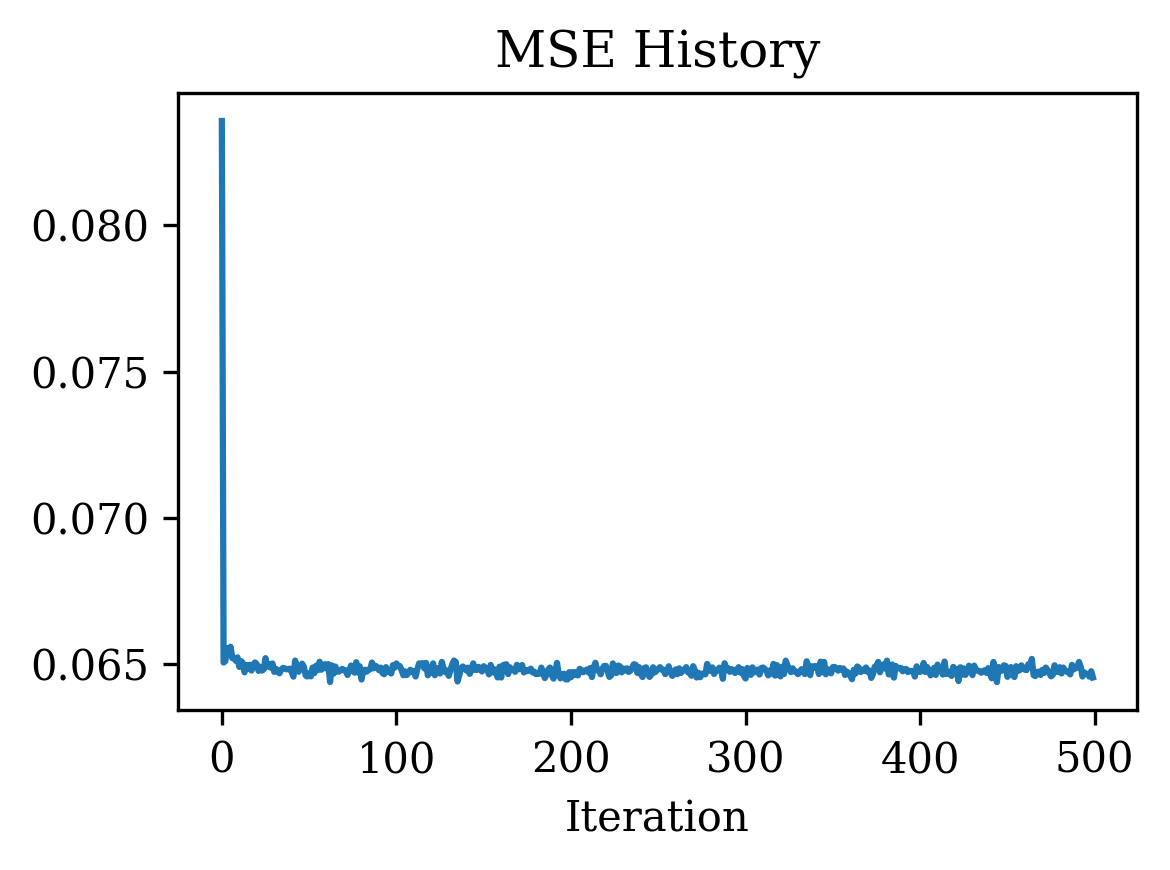

In [16]:
fig = plt.figure(figsize=(4, 3), dpi=300)
plt.plot(mse_history[::10])
plt.title('MSE History')
plt.xlabel('Iteration')
fig.tight_layout()
#fig.savefig('mse_history.png')
plt.show()

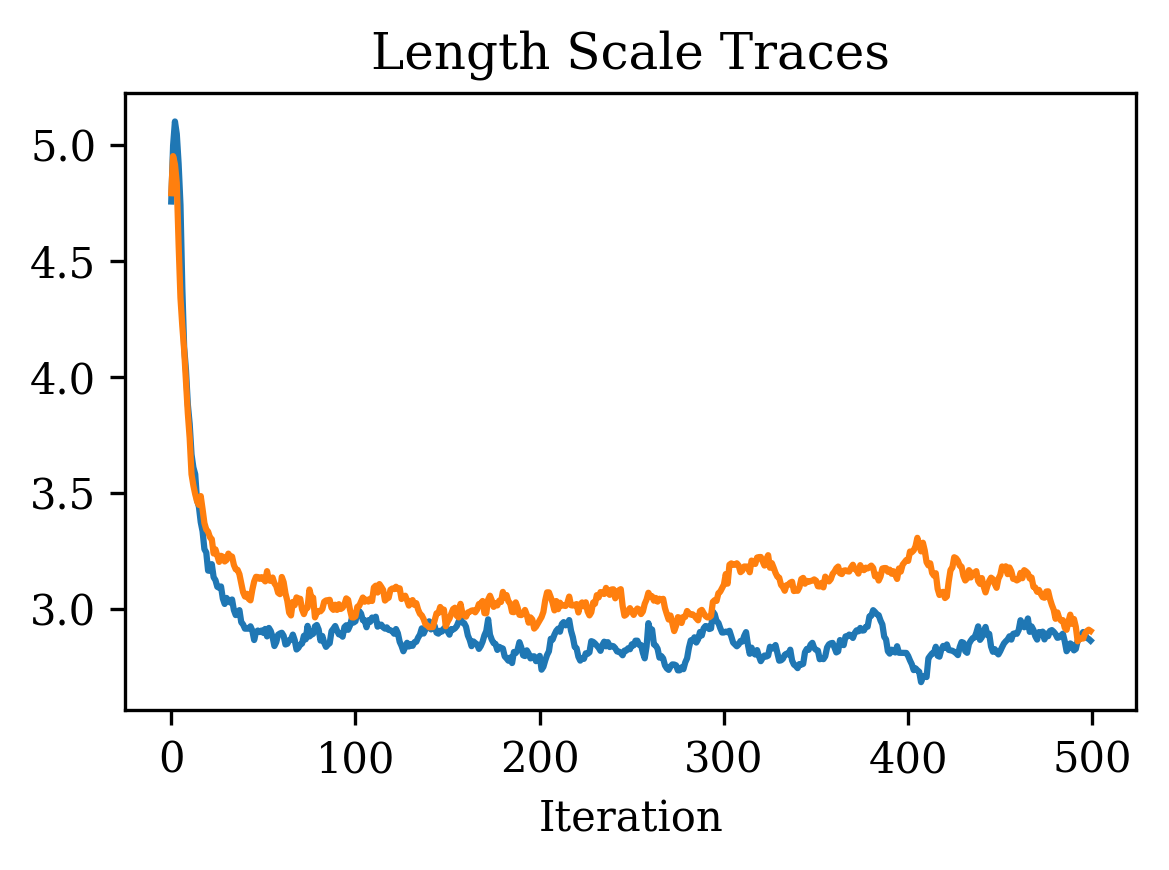

In [17]:
fig = plt.figure(figsize=(4, 3), dpi=300)
for j in range(2):
    plt.plot(theta_sample[::10, j])
plt.title('Length Scale Traces')
plt.xlabel('Iteration')
fig.tight_layout()
#fig.savefig('theta_traces.png')
plt.show()

In [18]:
burn = 1000
thin = 40
ts_len = 45

factor1_median_odor_B = np.zeros((100, ts_len))
factor2_median_odor_B = np.zeros((100, ts_len))
factor1_median_odor_C = np.zeros((100, ts_len))
factor2_median_odor_C = np.zeros((100, ts_len))
for i in range(100):
    factor1_median_odor_B[i, :] = np.median(F_sample[i * thin + burn, :(41 * ts_len), 0].reshape((41, ts_len)), axis=0)
    factor2_median_odor_B[i, :] = np.median(F_sample[i * thin + burn, :(41 * ts_len), 1].reshape((41, ts_len)), axis=0)
    factor1_median_odor_C[i, :] = np.median(F_sample[i * thin + burn, (41 * ts_len):, 0].reshape((37, ts_len)), axis=0)
    factor2_median_odor_C[i, :] = np.median(F_sample[i * thin + burn, (41 * ts_len):, 1].reshape((37, ts_len)), axis=0)

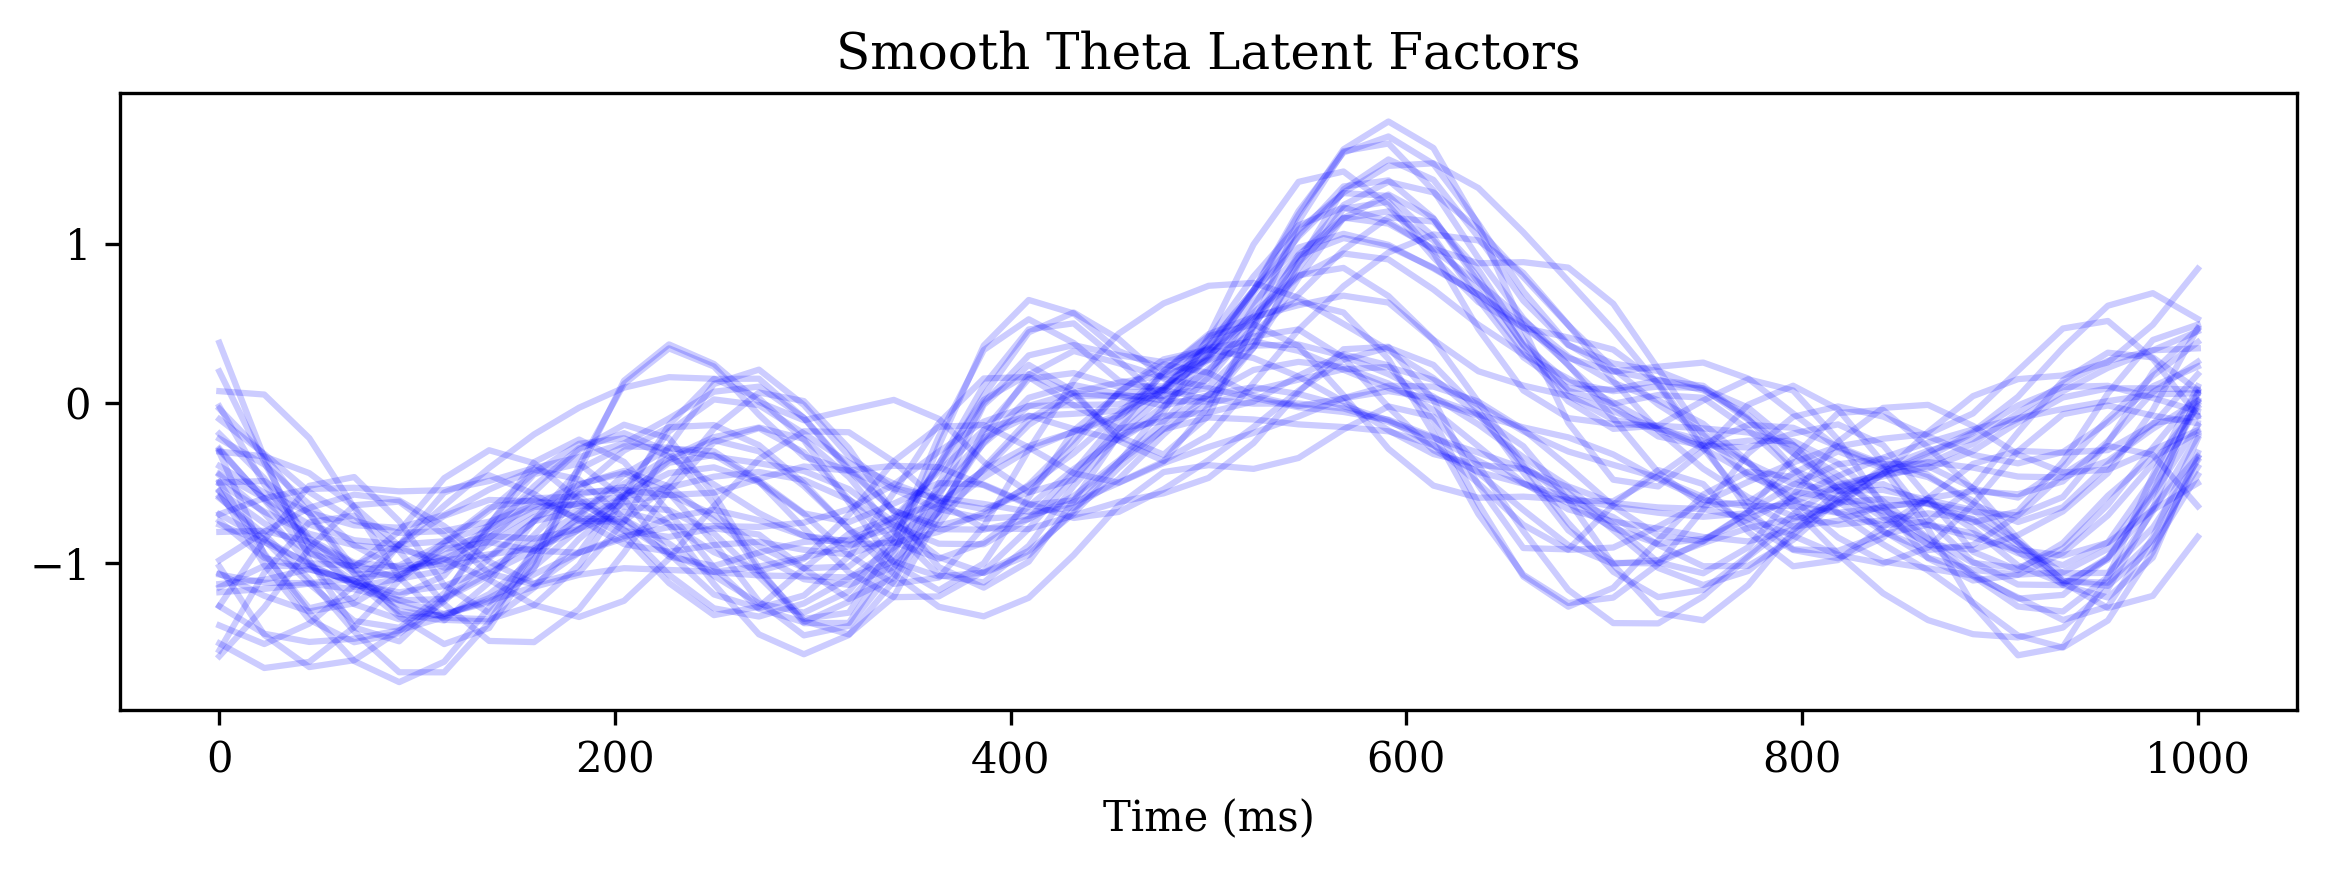

In [19]:
fig = plt.figure(figsize=(8, 3), dpi=300)
x = np.linspace(0, 1000, 45)
for i in range(20):
    plt.plot(x, F_sample[i * thin + burn, :45, 0], color='blue', alpha=0.2)
    plt.plot(x, F_sample[i * thin + burn, :45, 1], color='blue', alpha=0.2)
plt.title('Smooth Theta Latent Factors')
plt.xlabel('Time (ms)')
fig.tight_layout()
plt.savefig('trial.png')
plt.show()

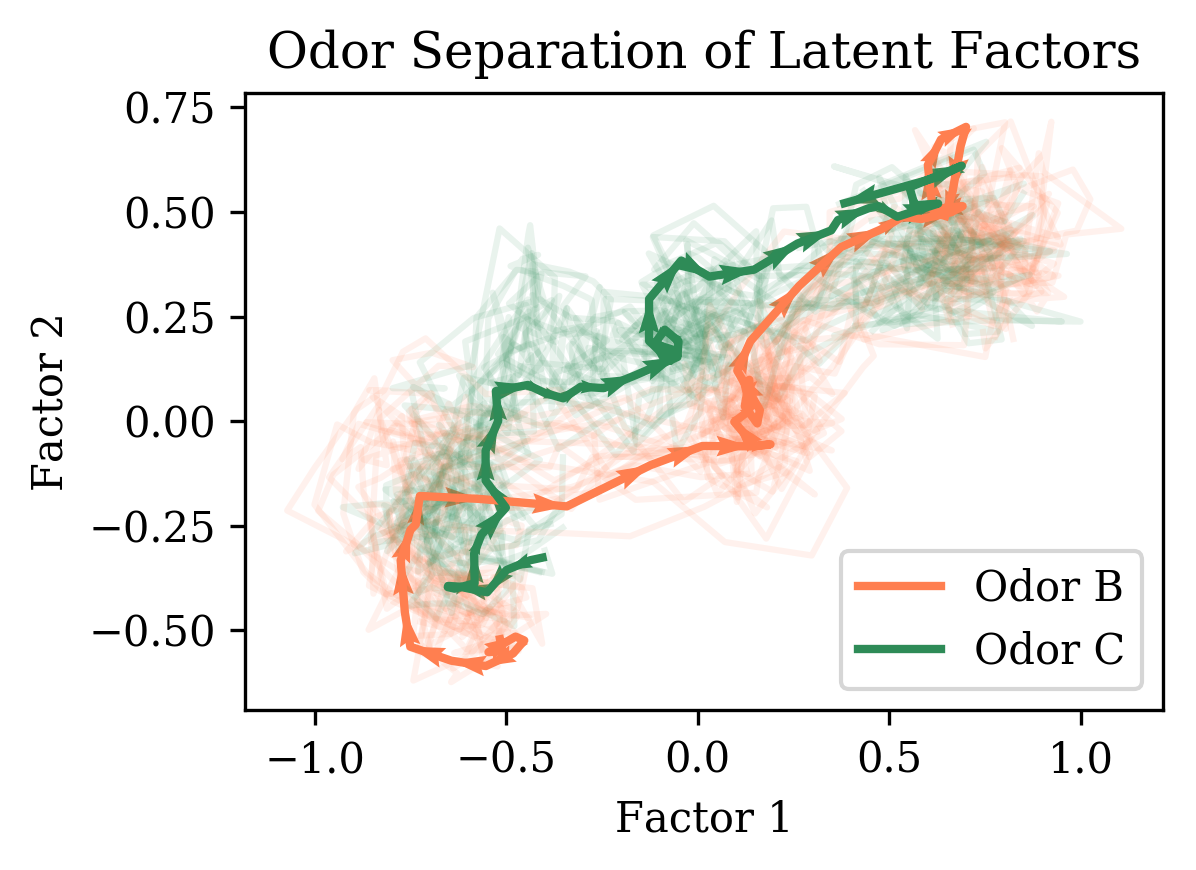

In [52]:
fig, ax = plt.subplots(figsize=(4, 3), dpi=300)

for i in range(20):
    plt.plot(factor1_median_odor_B[i, :], factor2_median_odor_B[i, :], color='coral', alpha=0.1)
    plt.plot(factor1_median_odor_C[i, :], factor2_median_odor_C[i, :], color='seagreen', alpha=0.1)

plt.plot(np.median(factor1_median_odor_B, axis=0), np.median(factor2_median_odor_B, axis=0), 
         color='coral', lw=2, label='Odor B')

x1 = np.median(factor1_median_odor_B, axis=0)
y1 = np.median(factor2_median_odor_B, axis=0)
plt.quiver(x1[:-1], y1[:-1], x1[1:]-x1[:-1], y1[1:]-y1[:-1], scale_units='xy', angles='xy', scale=1, color='coral')

plt.plot(np.median(factor1_median_odor_C, axis=0), np.median(factor2_median_odor_C, axis=0), 
         color='seagreen', lw=2, label='Odor C')

x2 = np.median(factor1_median_odor_C, axis=0)
y2 = np.median(factor2_median_odor_C, axis=0)
plt.quiver(x2[:-1], y2[:-1], x2[1:]-x2[:-1], y2[1:]-y2[:-1], scale_units='xy', angles='xy', scale=1, color='seagreen')

plt.title('Odor Separation of Latent Factors')
plt.xlabel('Factor 1')
plt.ylabel('Factor 2')
plt.legend()

fig.tight_layout()
plt.savefig('replay.png')
plt.show()

In [20]:
from scipy.linalg import expm, logm

In [21]:
def create_symmetric_matrix(upper, dim=5):
    """
    Create a symmetric matrix with elements in the upper triangle.
    
    Args
        upper: (numpy array) vector with concatenated rows in the upper triangle
        dim: (int) square matrix dimension
    """
    mat = np.zeros((dim, dim))
    current = 0
    for i in range(dim):  # fill in the upper triangle
        end = current + dim - i
        mat[i, i:] = upper[current:end]
        current = end
    for i in range(1, dim):  # fill in the lower triangle
        for j in range(i):
            mat[i, j] = mat[j, i]
    return mat

In [22]:
Y_hat_odor_B = np.zeros((100, 45, 21))
Y_hat_odor_C = np.zeros((100, 45, 21))
for i in range(100):
    F_median_odor_B = np.transpose(np.stack([factor1_median_odor_B[0, :], factor2_median_odor_B[0, :]]))
    loading_odor_B = loading_sample[i * thin + burn, :, :]
    Y_log_odor_B = np.matmul(F_median_odor_B, loading_odor_B)
    for j in range(45):
        cov = expm(create_symmetric_matrix(Y_log_odor_B[j, :], 6))
        D_inverse = np.linalg.inv(np.diag(np.sqrt(np.diagonal(cov))))
        corr = np.matmul(np.matmul(D_inverse, cov), D_inverse)                  
        Y_hat_odor_B[i, j, :] = corr[np.triu_indices(6)]
    F_median_odor_C = np.transpose(np.stack([factor1_median_odor_C[0, :], factor2_median_odor_C[0, :]]))
    loading_odor_C = loading_sample[i * thin + burn, :, :]
    Y_log_odor_C = np.matmul(F_median_odor_C, loading_odor_C)
    for j in range(45):
        cov = expm(create_symmetric_matrix(Y_log_odor_C[j, :], 6))
        D_inverse = np.linalg.inv(np.diag(np.sqrt(np.diagonal(cov))))
        corr = np.matmul(np.matmul(D_inverse, cov), D_inverse)   
        Y_hat_odor_C[i, j, :] = corr[np.triu_indices(6)]

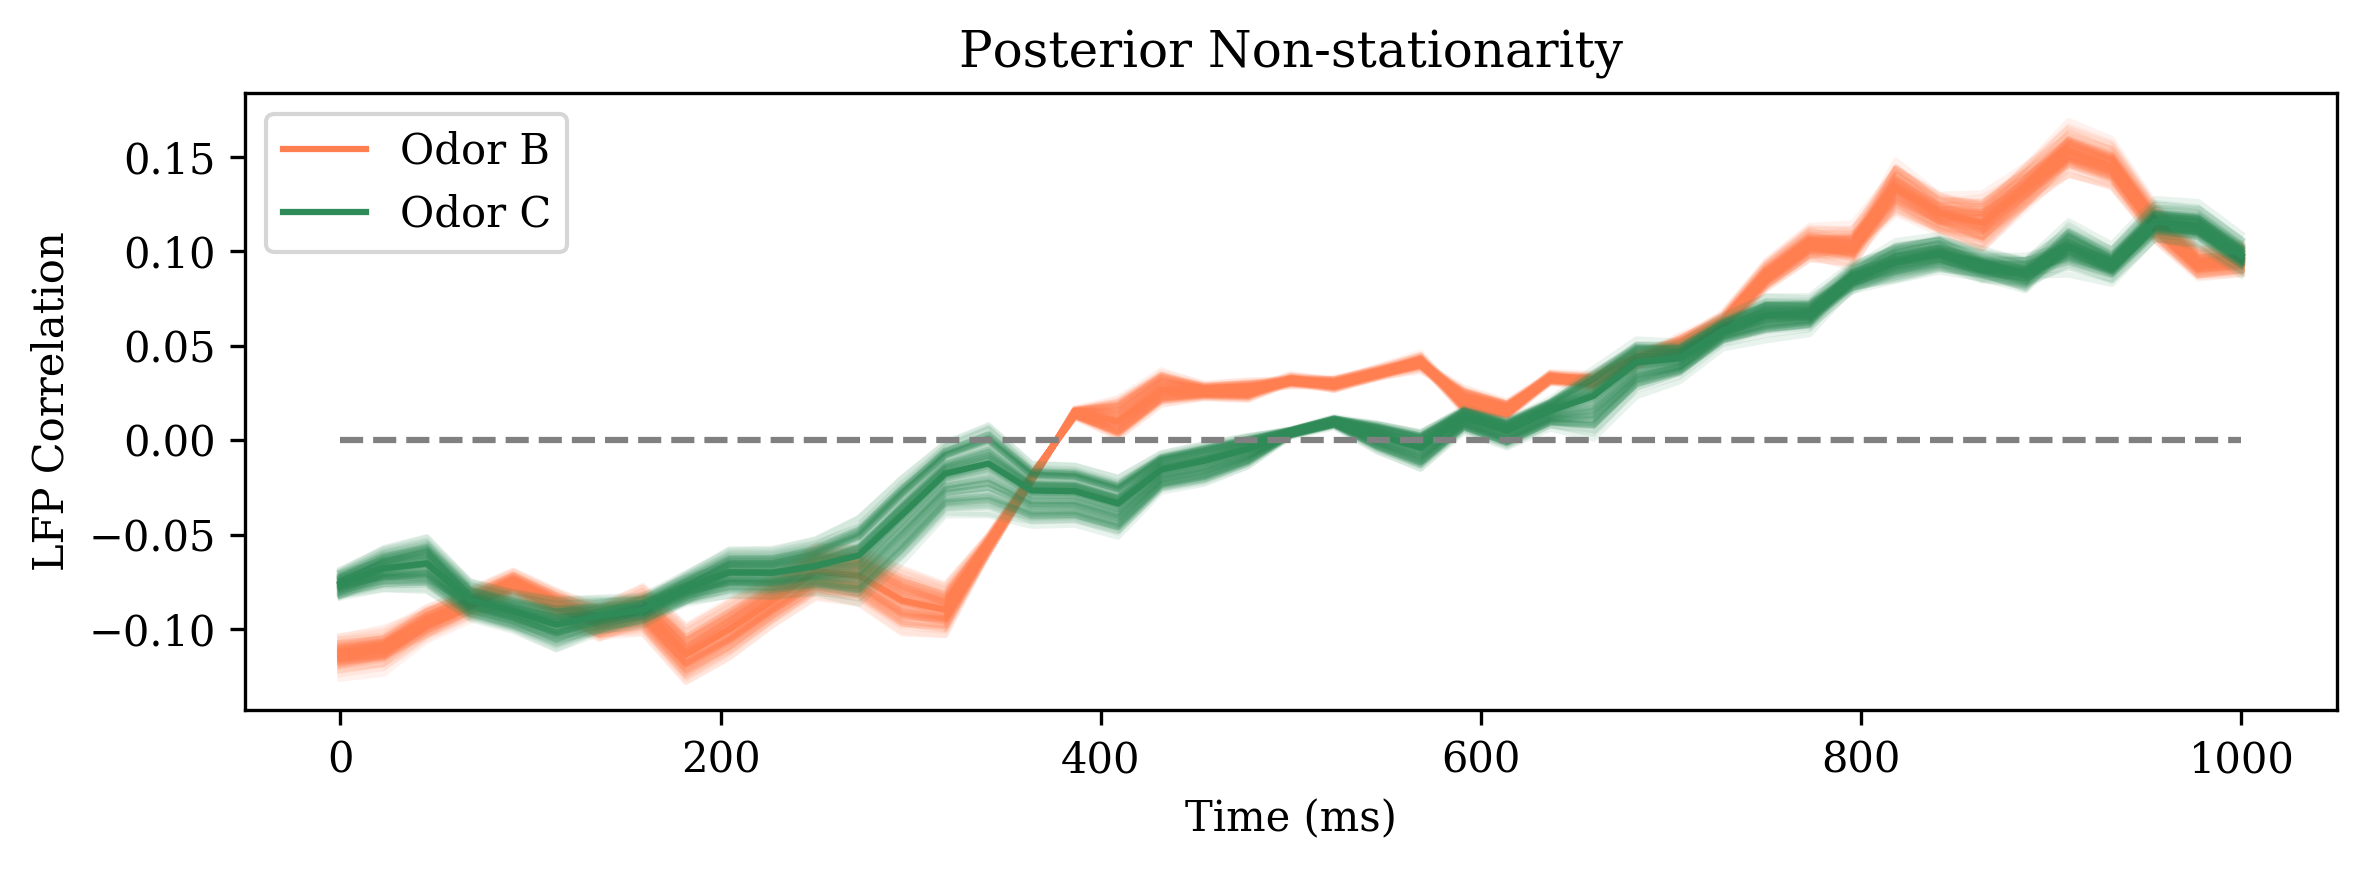

In [23]:
x = np.linspace(0, 1000, 45)
j = 2
fig = plt.figure(figsize=(8, 3), dpi=300)
for i in range(100):
    plt.plot(x, Y_hat_odor_B[i, :, j], color='coral', alpha=0.1)
plt.plot(x, np.median(Y_hat_odor_B[:, :, j], axis=0), color='coral', label='Odor B')
for i in range(100):
    plt.plot(x, Y_hat_odor_C[i, :, j], color='seagreen', alpha=0.1)
plt.plot(x, np.median(Y_hat_odor_C[:, :, j], axis=0), color='seagreen', label='Odor C')
plt.plot([0, 1000], [0, 0], '--', color='gray')
plt.title('Posterior Non-stationarity')
plt.xlabel('Time (ms)')
plt.ylabel('LFP Correlation')
plt.legend()
fig.tight_layout()
plt.savefig('test.png')
plt.show()